In [1]:
!nvidia-smi

Mon Jan 15 09:53:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.33                 Driver Version: 546.33       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   34C    P8              11W /  40W |    634MiB /  8192MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


TensorFlow Version: 2.15.0
Num GPUs Available:  0


C:\Users\Atique\AppData\Local\Temp\ipykernel_21112\3718260442.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
C:\Users\Atique\AppData\Local\Temp\ipykernel_21112\3718260442.py:11: UserWarning: No GPU found. Please ensure you have installed TensorFlow correctly
  warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')


In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13519095038338706777
 xla_global_id: -1]

# Importing Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from tensorflow.keras import layers, models

# Data Handling

In [5]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
'PlantVillage',
shuffle=True,
batch_size=32)

Found 16011 files belonging to 10 classes.


In [6]:
len(dataset)

501

[[[175. 182. 190.]
  [175. 182. 190.]
  [174. 181. 189.]
  ...
  [ 96.  95. 100.]
  [102. 101. 106.]
  [124. 123. 128.]]

 [[171. 178. 186.]
  [171. 178. 186.]
  [170. 177. 185.]
  ...
  [126. 125. 130.]
  [122. 121. 126.]
  [117. 116. 121.]]

 [[168. 175. 183.]
  [167. 174. 182.]
  [166. 173. 181.]
  ...
  [128. 127. 132.]
  [116. 115. 120.]
  [121. 120. 125.]]

 ...

 [[167. 170. 179.]
  [165. 168. 177.]
  [162. 165. 174.]
  ...
  [151. 149. 154.]
  [151. 149. 154.]
  [149. 147. 152.]]

 [[165. 168. 177.]
  [163. 166. 175.]
  [161. 164. 173.]
  ...
  [149. 147. 152.]
  [138. 136. 141.]
  [114. 112. 117.]]

 [[162. 165. 174.]
  [162. 165. 174.]
  [162. 165. 174.]
  ...
  [145. 143. 148.]
  [141. 139. 144.]
  [110. 108. 113.]]]
1


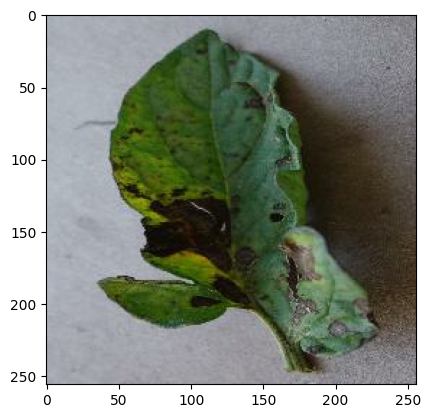

In [7]:
for image, label in dataset.take(1):
    print(image[1].numpy())
    print(label[1].numpy())
    plt.imshow(image[1].numpy().astype('uint8'))

In [8]:
class_name=dataset.class_names
class_name

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

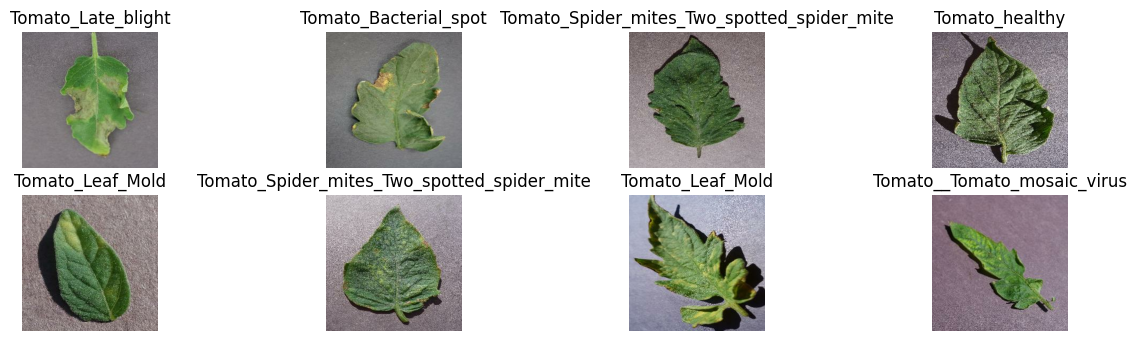

In [9]:
plt.figure(figsize=(15,6))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_name[labels_batch[i]])
        plt.axis('off')

# Splitting Dataset

In [15]:
def split_dataset(ds, train_split=0.75, val_split=0.15, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert train_split+val_split+test_split ==1
    
    ds_size=len(ds)
    if shuffle:
        dataset.shuffle(shuffle_size, seed=42)
        
    train_size= int(ds_size* train_split)
    val_size= int(math.ceil(ds_size* val_split))
    
    train_ds= ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = split_dataset(dataset)

In [17]:
len(train_ds)

375

In [18]:
len(val_ds)

76

In [19]:
len(test_ds)

50

# Caching & Prefetching

In [20]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building a Model

In [21]:
resize_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(64,64),
    layers.experimental.preprocessing.Rescaling(1./255),
])

In [22]:
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [31]:
input_shape=(32, 128,128, 3)
n_channels=10

model= models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.05),
    layers.Dense(n_channels, activation='softmax')
])

model.build(input_shape=input_shape)

In [32]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (32, 62, 62, 32)          896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (32, 31, 31, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (32, 29, 29, 64)          18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (32, 14, 14, 64)          0         
 g2D)                                                 

In [33]:
model.compile(

    optimizer='adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [34]:
history= model.fit(

    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=50
)

Epoch 1/50
375/375 [==============================] - 23s 59ms/step - loss: 1.7918 - accuracy: 0.3625 - val_loss: 1.3700 - val_accuracy: 0.5387
Epoch 2/50
375/375 [==============================] - 10s 28ms/step - loss: 1.2742 - accuracy: 0.5670 - val_loss: 1.1307 - val_accuracy: 0.6077
Epoch 3/50
375/375 [==============================] - 10s 26ms/step - loss: 1.0469 - accuracy: 0.6412 - val_loss: 0.8233 - val_accuracy: 0.7171
Epoch 4/50
375/375 [==============================] - 10s 26ms/step - loss: 0.8537 - accuracy: 0.7022 - val_loss: 0.6953 - val_accuracy: 0.7516
Epoch 5/50
375/375 [==============================] - 10s 26ms/step - loss: 0.7193 - accuracy: 0.7505 - val_loss: 0.6392 - val_accuracy: 0.7751
Epoch 6/50
375/375 [==============================] - 10s 26ms/step - loss: 0.6150 - accuracy: 0.7874 - val_loss: 0.4855 - val_accuracy: 0.8289
Epoch 7/50
375/375 [==============================] - 10s 26ms/step - loss: 0.5686 - accuracy: 0.8030 - val_loss: 0.5286 - val_accuracy:

In [35]:
scores=model.evaluate(test_ds)

50/50 [==============================] - 2s 50ms/step - loss: 0.2245 - accuracy: 0.9240


In [36]:
acc= history.history['accuracy']
val_acc=history.history['val_accuracy']

loss= history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Loss vs Epoch')

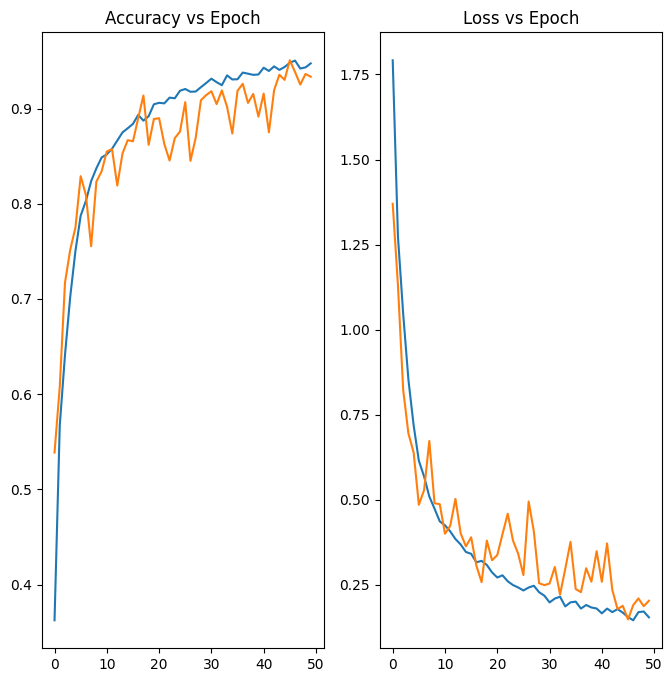

In [37]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.title('Accuracy vs Epoch')

plt.subplot(1,2,2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.title('Loss vs Epoch')

In [30]:
model_version=1
model.save(f'../models/{model_version}')

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
